In [1]:
## Processing
import numpy as np
import pandas as pd
from sklearn.neighbors import KernelDensity
from Bio import SeqIO
from os import path
import mdtraj as md

## Custom package
import sys
sys.path.insert(1, '../scripts')
import parseaf as pa

## Visualization
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams.update({'font.size': 12})
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = "Arial"

## Colors
cscheme = {'pos':'#0177BB', 'neg':'#CB3627', 'dis':'#828282', 'helix':'#009988', 'sheet':'#EE7733', 'cr':'#AA4499',
          'null':"black"}

### Add a direct comparison of the prediction of this study and that obtained using existing tools

In [3]:
df_hc = pd.read_csv('../../data/charged_regions/cr_trimmed_filtered_aflabel.csv')

In [4]:
df_hc.head(10)

,orf,gene,seq.len,left.bound,right.bound,region.seq,region.len,charge.asymmetry,frac.charge,uni_id,orf_label,kappa,label
0,YAL011W,SWC3,626,5,53,RTRSKESSIEQKPASRTRTRSRRGKRGRDDDDDDDDEESDDAYDEVGND,49,0.017593,0.591837,P31376,verified,0.539053,disordered
1,YAL011W,SWC3,626,169,261,RLFILKNDKIEQKWQDEQELKKKEKELKRKNDAEAKRLRMEERKRQ...,93,0.052936,0.559140,P31376,verified,0.098538,helix
2,YAL011W,SWC3,626,361,424,KTAATEPEPKKADDENAEKQQSKEAKTTAESTQVDVKKEEEDVKEK...,64,0.007812,0.500000,P31376,verified,0.089231,disordered
3,YAL013W,DEP1,406,84,159,ESLKRPHEDEKEAIDEAKKMKVPGENEDESKEEEKSQELEEAIDSK...,76,0.138444,0.592105,P31385,verified,0.219047,disordered
4,YAL019W,FUN30,1132,463,538,ERETKRIRNTTKPKVVEDEDDDVDLEAIDDELPQSEHEDDDYEEED...,76,0.269474,0.644737,P31380,verified,0.498598,disordered
5,YAL024C,LTE1,1436,701,746,REFTFEDTKSLDEKKSTIDGLEKNYDNKENQESEYESTKKLDNSLD,46,0.035573,0.478261,P07866,verified,0.099060,disordered
6,YAL031C,GIP4,761,404,455,DCWKYIEKNYKTFDETNDLRENLKEKLERDKALYLEVKNAKSKLKK...,52,0.019231,0.480769,P39732,verified,0.173941,helix
7,YAL032C,PRP45,380,205,248,EALENADKKARQEIRSKMELKRLAMEQEMLAKESKLKELSQRAR,44,0.009740,0.477273,P28004,verified,0.086210,helix
8,YAL034W-A,MTW1,290,110,152,DLVIVDENELKKSEEKLREKVNDVELAFKKNEMLLKRVTKVKR,43,0.004228,0.511628,P39731,verified,0.165498,helix
9,YAL035W,FUN12,1003,66,132,KQSKKKQEKKVIEEKKDGKPILKSKKEKEKEKKEKEKQKKKEQAAR...,67,0.081908,0.611940,P39730,verified,0.084370,helix


In [8]:
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord

records = []
for index, row in df_hc.iterrows():
    rec = SeqRecord(Seq(row['region.seq']),
                    id=row['orf'], name=row['orf'],
                    description=row['gene'])
    records.append(rec)

In [9]:
with open("../../data/fldpnn/hcr_seqs.fasta", "w") as output_handle:
    SeqIO.write(records, output_handle, "fasta")

### Figure S5a and S5b difficult to see. Add Notches.

See `/figures/FigureS5.ipynb`.

### In their logistic regression model, the authors assign disorder to either PLDDT scores > 70 and coil prediction by DSSP or to a PLDDT<50. What is the probability of observing each case?

In [2]:
def get_percent_disorder(ss, bfactor, len_region):
    cnt_coil = 0
    cnt_lowconf = 0
    for i, label in enumerate(ss):
        if (label == 'C') and (bfactor[i] >= 70):
            cnt_coil += 1
        elif bfactor[i] < 50:
            cnt_lowconf += 1
    return cnt_coil, cnt_lowconf

In [3]:
def get_disorder_probs(fdir, df):
    tot_coil = 0
    tot_lowconf = 0
    for index, row in df.iterrows():
        uni_id = row['uni_id']
        fpath = fdir + 'AF-' + str(uni_id) + '-F1-model_v2.pdb'
        left_bound = row['left.bound']
        right_bound = row['right.bound']
        if path.exists(fpath):
            af_pdb = pa.read_af_output(fdir, uni_id)
            ss = md.compute_dssp(af_pdb, simplified=True)[0]
            region_ss = ss[left_bound:(right_bound+1)]
            bfactor = pa.read_bfactor_from_pdb(fpath)[left_bound:(right_bound+1)]
            len_region = right_bound - left_bound + 1

            res = get_percent_disorder(region_ss, bfactor, len_region)
            tot_coil += res[0]
            tot_lowconf += res[1]
    tot = tot_coil + tot_lowconf

    return tot_coil / tot, tot_lowconf / tot

In [4]:
fdir = '/Users/rosalindpan/drummondlab/hcrpaper_data/scerevisiae_alphafold/'

For highly charged regions

In [50]:
df = pd.read_csv("../../data/charged_regions/cr_trimmed_filtered_aflabel.csv")
prob_coil, prob_lowconf = get_disorder_probs(fdir, df)

print("For a residue that is classified as disordered, the probability that it's a confidently predicted coil (PLDDT score > 70 and coil prediction by DSSP) is {:.2f} and the probability that it has low confidence score (PLDDT < 50) is {:.2f}.".format(prob_coil, prob_lowconf))

/Users/rosalindpan/opt/anaconda3/envs/env_hcr/lib/python3.9/site-packages/mdtraj/formats/pdb/pdbfile.py:200: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  warnings.warn('Unlikely unit cell vectors detected in PDB file likely '


For a residue that is classified as disordered, the probability that it's a confidently predicted coil (PLDDT score > 70 and coil prediction by DSSP) is 0.10 and the probability that it has low confidence score (PLDDT < 50) is 0.90.


For randomly drawn regions

In [53]:
df_random = pd.read_csv('../../data/af_regions/random_af_regions_low_thresh.csv')
df_random.rename({'left_bound': 'left.bound', 'right_bound': 'right.bound'}, axis=1, inplace=True)
prob_coil, prob_lowconf = get_disorder_probs(fdir, df_random)

print("For a residue that is classified as disordered, the probability that it's a confidently predicted coil (PLDDT score > 70 and coil prediction by DSSP) is {:.2f} and the probability that it has low confidence score (PLDDT < 50) is {:.2f}.".format(prob_coil, prob_lowconf))

/Users/rosalindpan/opt/anaconda3/envs/env_hcr/lib/python3.9/site-packages/mdtraj/formats/pdb/pdbfile.py:200: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  warnings.warn('Unlikely unit cell vectors detected in PDB file likely '


For a residue that is classified as disordered, the probability that it's a confidently predicted coil (PLDDT score > 70 and coil prediction by DSSP) is 0.31 and the probability that it has low confidence score (PLDDT < 50) is 0.69.


For all regions

In [5]:
df = pd.read_csv('../../data/af_regions/sc_af_regions_all.csv')
df.rename({'start': 'left.bound', 'end': 'right.bound'}, axis=1, inplace=True)
prob_coil, prob_lowconf = get_disorder_probs(fdir, df)

print("For a residue that is classified as disordered, the probability that it's a confidently predicted coil (PLDDT score > 70 and coil prediction by DSSP) is {:.2f} and the probability that it has low confidence score (PLDDT < 50) is {:.2f}.".format(prob_coil, prob_lowconf))

/Users/rosalindpan/opt/anaconda3/envs/env_hcr/lib/python3.9/site-packages/mdtraj/formats/pdb/pdbfile.py:200: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  warnings.warn('Unlikely unit cell vectors detected in PDB file likely '


For a residue that is classified as disordered, the probability that it's a confidently predicted coil (PLDDT score > 70 and coil prediction by DSSP) is 0.01 and the probability that it has low confidence score (PLDDT < 50) is 0.99.


### What is the prevalence of highly-charged sequences in other proteomes (such as the human one)?

In [2]:
records = {}
with open('../../data/ref_proteomes/Homo_sapiens.fasta') as handle:
    for record in SeqIO.parse(handle, 'fasta'):
        records[record.id] = str(record.seq)

In [3]:
len(records)

114963

In [4]:
cr_hs = pd.read_csv('../../data/charged_regions/cr_homo_sapiens.csv', comment='#')
cr_hs.head(10)

,orf,gene,seq.len,left.bound,right.bound,region.seq,region.len,charge.asymmetry,frac.charge,kappa1,kappa2
0,NP_000029.2,adenomatous,2843,1532,1580,NGNETESEQPKESNENQEKEAEKTIDSEKDLLDDSDDDDIEILEECIIS,49,0.217687,0.489796,0.079031,0.279810
1,NP_000030.1,apolipoprotein,267,91,152,TQEFWDNLEKETEGLRQEMSKDLEEVKAKVQPYLDDFQKKWQEEME...,62,0.029271,0.435484,0.051507,0.138749
2,NP_000032.1,apolipoprotein,317,224,267,AQAWGERLRARMEEMGSRTRDRLDEVKEQVAEVRAKLEEQAQQI,44,0.001196,0.431818,0.042555,0.114889
3,NP_000042.3,serine-protein,3056,9,53,ICCRQLEHDRATERKKEVEKFKRLIRDPETIKHLDRHSDSKQGKY,45,0.043556,0.488889,0.029856,0.069648
4,NP_000055.2,complement,1663,1488,1541,CTRFYHPEKEDGKLNKLCRDELCRCAEENCFIQKSDDKVTLEERLD...,54,0.006667,0.444444,0.034862,0.089707
5,NP_000059.3,voltage-dependent,2266,938,1040,RQGGSRESRSGSPRTGADGEHRRHRAHRRPGEEGPEDKAERRARHR...,103,0.049225,0.485437,0.144546,0.322122
6,NP_000060.2,voltage-dependent,1873,669,715,LTSAQKAKAEEKKRRKMSKGLPDKSEEEKSTMAKKLEQKPKGEGIPT,47,0.034816,0.468085,0.078154,0.201243
7,NP_000078.3,cGMP-gated,686,88,155,NNSSNKDQEPEEKKKKKKEKKSKSDDKNENKNDPEKKKKKKDKEKK...,68,0.024310,0.720588,0.089758,0.130267
8,NP_000086.2,cartilage,757,329,385,LVRNPDQRNTDEDKWGDACDNCRSQKNDDQKDTDQDGRGDACDDDI...,57,0.052632,0.473684,0.067017,0.172349
9,NP_000094.2,aromatase,503,235,280,KISWLYKKYEKSVKDLKDAIEVLIAEKRRRISTEEKLEECMDFATE,46,0.000000,0.478261,0.076768,0.178206


In [5]:
print('We extracted {} highly charged regions from the Human proteome'.format(len(cr_hs)))
print('About {:.1f}% of protein-coding genes encode at least one highly charged region.'.format(cr_hs['orf'].nunique() / len(records) * 100))

We extracted 29013 highly charged regions from the Human proteome
About 16.5% of protein-coding genes encode at least one highly charged region.


### Fig 2A: why is there a sudden jump in highly-charged and Random distributions at low/high fractions?

In [2]:
df = pd.read_csv('../../data/charged_regions/cr_trimmed_filtered.csv',
                comment="#")

In [3]:
tot_len = 0
for index, row in df.iterrows():
    tot_len += len(row['region.seq'])

In [4]:
# Load data
hits_disordered_frac = np.loadtxt("../../data/af_ss_processed/hits_trimmed_disordered_frac.txt")
rand_disordered_frac = np.loadtxt("../../data/af_ss_processed/rand_trimmed_disordered_frac.txt")
idr_disordered_frac = np.loadtxt("../../data/af_ss_processed/idr_disordered_frac.txt")

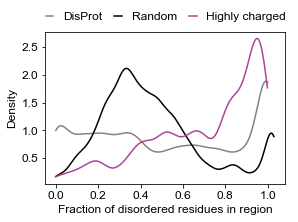

In [8]:
fig, ax = plt.subplots(1, figsize=(4.3,2.8),
                         sharex=True, sharey=True)

sns.kdeplot(hits_disordered_frac, color=cscheme['dis'], label='DisProt', bw_adjust=0.5, cut=0)
sns.kdeplot(rand_disordered_frac, color=cscheme['null'], label='Random', bw_adjust=0.5, cut=0)
sns.kdeplot(idr_disordered_frac, color=cscheme['cr'], label='Highly charged', bw_adjust=0.5, cut=0)

plt.xlabel('Fraction of disordered residues in region')
plt.ylabel('Density')
L = plt.legend(bbox_to_anchor=(1.05, 1.2), ncol=3, columnspacing=1, frameon=False, handlelength=.65)

plt.savefig('../../figures/plots/Figure2A.png', dpi=300, bbox_inches='tight')
#plt.tight_layout()
plt.show()

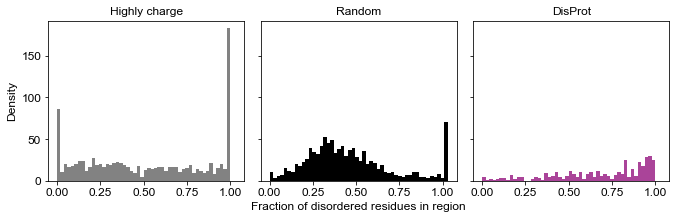

In [44]:
fig, axes = plt.subplots(1, 3, figsize=(10, 3.5),
                         sharex=True, sharey=True)
ax1, ax2, ax3 = axes

ax1.hist(hits_disordered_frac, bins=50, color=cscheme['dis'])
ax1.set_title('Highly charge', fontsize=12)

ax2.hist(rand_disordered_frac, bins=50, color=cscheme['null'])
ax2.set_title('Random', fontsize=12)

ax3.hist(idr_disordered_frac, bins=50, color=cscheme['cr'])
ax3.set_title('DisProt', fontsize=12)

ax1.set_ylabel('Density')

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)
plt.xlabel("Fraction of disordered residues in region")

#plt.savefig('./plots/Figure2A.png', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

### Include an Uversky-like plot that κ vs FCR colored as helix/disordered as determined by AF

In [6]:
df = pd.read_csv("../../data/charged_regions/cr_trimmed_filtered_aflabel.csv")

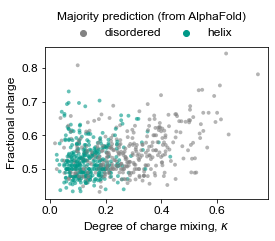

In [8]:
plt.figure(figsize=(4, 2.8))
sns.scatterplot(x = "kappa", y = "frac.charge", hue="label", data=df,
                palette=[cscheme["dis"], cscheme["helix"]], s=15, edgecolors=None, linewidth=0, alpha=0.6)
plt.xlabel("Degree of charge mixing, $\kappa$")
plt.ylabel("Fractional charge")
plt.legend(title="Majority prediction (from AlphaFold)",
           bbox_to_anchor=(0.95, 1.3), ncol=2, frameon=False, columnspacing=1)
plt.savefig('../../figures/plots/FigureS2B-alt.png', dpi=300, bbox_inches='tight')
plt.show()